<a href="https://colab.research.google.com/github/federicOO1/LAB-IA/blob/main/Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## import librerie


In [2]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
import matplotlib.pyplot as plt
from torchvision import transforms
import os
import numpy as np
import PIL
import warnings
warnings.filterwarnings('ignore')

In [3]:
!pip install rasterio
import rasterio
from rasterio.plot import reshape_as_image

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
os.chdir("/content/drive/MyDrive/PotsdamDataset")

In [6]:
class PotsdamDataset(Dataset):
    def __init__(self, dataset_folder):
        self.dataset_folder = dataset_folder
        self.image_paths = []
        self.world_file_paths = []
        self.mask_paths = []

        # Leggi i percorsi delle immagini, dei file .tfw e delle maschere
        end_RGBIR_folder = os.listdir(dataset_folder)[0]
        end_LABELS_folder = os.listdir(dataset_folder)[1]

        RGBIR_folder = data_folder + '/' + end_RGBIR_folder
        LABELS_folder = data_folder + '/' + end_LABELS_folder

        for file_name in os.listdir(RGBIR_folder):
            if file_name.endswith('.tif'):
                image_path = os.path.join(RGBIR_folder, file_name)
                world_file_path = os.path.join(RGBIR_folder, file_name.replace('.tif', '.tfw'))

                if os.path.exists(world_file_path):
                    self.image_paths.append(image_path)
                    self.world_file_paths.append(world_file_path)


        for label_name in os.listdir(LABELS_folder):
            mask_path = os.path.join(LABELS_folder, label_name)

            if os.path.exists(mask_path):
              self.mask_paths.append(mask_path)

    def __len__(self):
        return len(self.image_paths)

    def load_world_file(self, world_file_path):
          lines = open(world_file_path).readlines()
          try:
              parameters = [float(line.strip()) for line in lines if line.strip()]
              if len(parameters) == 6:
                  return parameters
              else:
                  raise ValueError("Il file .tfw non contiene 6 parametri.")
          except Exception as e:
              print(f"Errore durante la lettura dei parametri di georeferenziazione: {str(e)}")
              return None

    def convert_labels_to_tensor(self, rgb_label):
      color_image = reshape_as_image(rgb_label)
      # Definisci i colori delle classi nella maschera RGB
      colors_to_labels = {
          (255, 255, 255): 0,  # Impervious surfaces -> Classe 0
          (0, 0, 255): 1,  # Building -> Classe 1
          (0, 255, 255): 2,  # Low vegetation -> Classe 2
          (0, 255, 0): 3,  # Tree -> Classe 3
          (255, 255, 0): 4,  # Car -> Classe 4
          (255, 0, 0): 5  # Clutter/background -> Classe 5
      }

      # Inizializza un'immagine di etichette con valori di sfondo (0)
      height, width, _ = color_image.shape
      class_label = np.zeros((height, width), dtype=np.int32)

      for i in range(height):
          for j in range(width):
              pixel_color = tuple(color_image[i, j])
              #print(pixel_color)
              class_label[i, j] = colors_to_labels.get(pixel_color, -1)  # -1 per i colori non mappati
              #print(class_label[i, j])


      # Stampa l'array di classi risultante
      class_label_tensor = torch.tensor(class_label, dtype=torch.long)

      return class_label_tensor

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        world_file_path = self.world_file_paths[idx]
        mask_path = self.mask_paths[idx]

        # Carica l'immagine TIFF utilizzando la libreria rasterio
        image = rasterio.open(image_path).read()

        # Carica i parametri di georeferenziazione dal file .tfw
        world_params = self.load_world_file(world_file_path)

        # Carica la maschera con rasterio
        mask = rasterio.open(mask_path).read()

        # Converti la maschera RGB nel formato appropriato per CrossEntropyLoss
        label = self.convert_labels_to_tensor(mask)

        # Restituisci l'immagine, la maschera e i parametri di georeferenziazione
        return image, label, world_params


In [7]:
# Definisci il percorso della cartella contenente i dati .tif e .tfw
data_folder = "/content/drive/MyDrive/PotsdamDataset"

# Crea un'istanza del dataset
dataset = PotsdamDataset(data_folder)

size = len(dataset)
train_size = int(0.7 * size)
val_size = int(0.15 * size)
test_size = int(size - train_size - val_size)

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

In [8]:
rgb_label = rasterio.open(dataset.mask_paths[31]).read()
# Definisci i colori delle classi nella maschera RGB
colors_to_labels = {
    (255, 255, 255): 0,  # Impervious surfaces -> Classe 0
    (0, 0, 255): 1,  # Building -> Classe 1
    (0, 255, 255): 2,  # Low vegetation -> Classe 2
    (0, 255, 0): 3,  # Tree -> Classe 3
    (255, 255, 0): 4,  # Car -> Classe 4
    (255, 0, 0): 5  # Clutter/background -> Classe 5
}
color_image = np.array(rgb_label)

assert color_image.shape == (3, 6000, 6000), "Le dimensioni dell'immagine devono essere (3, 6000, 6000)"

# Rappresenta color_array come un array (6, 3)
color_array = np.array(list(colors_to_labels.keys()))

# Reshape l'immagine per renderla compatibile con l'operazione di broadcasting
color_image_reshaped = color_image.transpose(1, 2, 0).reshape(-1, 3)

# Calcola le differenze tra i colori nella maschera RGB e i colori delle classi
color_diffs = np.sum(np.abs(color_image_reshaped[:, None, :] - color_array[None, :, :]), axis=-1)

# Trova l'indice del colore più vicino per ciascun pixel
closest_color_indices = np.argmin(color_diffs, axis=-1)

# Mappa gli indici di colore ai valori delle classi
class_label = np.where(np.min(color_diffs, axis=-1) == 0, closest_color_indices, -1)

# Reshape per tornare alle dimensioni dell'immagine originale
class_label = class_label.reshape(6000, 6000)

# Crea il tensore delle etichette di classe
class_label_tensor = torch.tensor(class_label, dtype=torch.long)



In [10]:
rgb_label = rasterio.open(dataset.mask_paths[31]).read()
color_image_2 = reshape_as_image(rgb_label)
# Definisci i colori delle classi nella maschera RGB
#print(color_image_2)

# Inizializza un'immagine di etichette con valori di sfondo (0)
height, width, _ = color_image_2.shape
print(height, width, _)
class_label_2 = np.zeros((height, width), dtype=np.int32)

for i in range(height):
    for j in range(width):
        pixel_color = tuple(color_image_2[i, j])
        #print(pixel_color)
        class_label_2[i, j] = colors_to_labels.get(pixel_color, -1)  # -1 per i colori non mappati
        #print(class_label_2[i, j])


# Stampa l'array di classi risultante
class_label_2_tensor = torch.tensor(class_label_2, dtype=torch.long)

6000 6000 3


In [20]:
truth = class_label == class_label_2
for riga in truth:
  for elem in riga:
    if elem == False:
      print("Merda")
print("Fiu!")


Fiu!


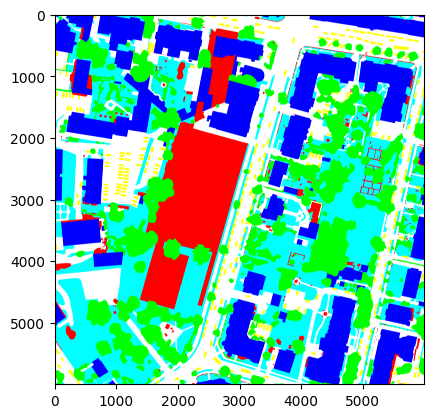

In [31]:
plt.imshow(rasterio.open(dataset.mask_paths[31]).read().transpose())
plt.show()